In [1]:
!pip install surprise
import pandas as pd
import json
import gzip
import numpy as np
import random
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise import SVD,SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
from surprise.model_selection.validation import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162996 sha256=9043ba6f2b94e716bb2308285f39e85f8c7251b8278846d401b7704d5605c298
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## loading datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
data_list = []

with open('/content/drive/MyDrive/295A project/Data/Clothes/Data/modcloth_final_data.json', 'r') as file:
    for line in file:
        data = json.loads(line)
        data_list.append(data)

In [4]:
df = pd.DataFrame(data_list)
df

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82785,807722,NaN,8,4.0,b,NaN,36,outerwear,NaN,5ft 8in,Jennifer,just right,fit,727820,8.50,average,Cute jacket!,Cute jacket!
82786,807722,NaN,12,5.0,ddd/f,NaN,34,outerwear,NaN,5ft 5in,Kelli,slightly long,small,197040,NaN,NaN,It's a beautiful jacket.,It's a beautiful jacket. I love how it's knit ...
82787,807722,NaN,12,5.0,dddd/g,36.0,32,outerwear,NaN,5ft 4in,elacount,just right,fit,102493,NaN,NaN,I love this blazer. It is,I love this blazer. It is a great office piece...
82788,807722,NaN,12,4.0,NaN,NaN,NaN,outerwear,NaN,5ft 3in,jennaklinner,just right,fit,756491,NaN,NaN,I love this blazer!! I wo,I love this blazer!! I wore it yesterday and g...


In [5]:
df['item_id'].nunique(),df['user_id'].nunique(),df['quality'].count()

(1378, 47958, 82722)

In [6]:
df['quality'].max(),df['quality'].min(),round(df['quality'].sum()/df['quality'].count(),2)

(5.0, 1.0, 3.95)

In [7]:
df['quality'].std(),df['quality'].var()

(0.9927831097381342, 0.9856183029813201)

In [8]:
from pandas._libs.missing import NA
sparsity = (df == 0 | df.isna()).any().astype(int).sum() / df.size
sparsity

6.710418595912013e-07

In [9]:
df.isna().sum()

item_id               0
waist             79908
size                  0
quality              68
cup size           6255
hips              26726
bra size           6018
category              0
bust              70936
height             1107
user_name             0
length               35
fit                   0
user_id               0
shoe size         54875
shoe width        64183
review_summary     6725
review_text        6725
dtype: int64

In [10]:
df=df.drop(['waist','hips','bust','shoe size','shoe width'],axis=1)

In [11]:
df.isna().sum()

item_id              0
size                 0
quality             68
cup size          6255
bra size          6018
category             0
height            1107
user_name            0
length              35
fit                  0
user_id              0
review_summary    6725
review_text       6725
dtype: int64

In [12]:
df.dropna(inplace=True)


In [13]:
df.isna().sum()

item_id           0
size              0
quality           0
cup size          0
bra size          0
category          0
height            0
user_name         0
length            0
fit               0
user_id           0
review_summary    0
review_text       0
dtype: int64

<Axes: title={'center': 'quality'}, ylabel='Frequency'>

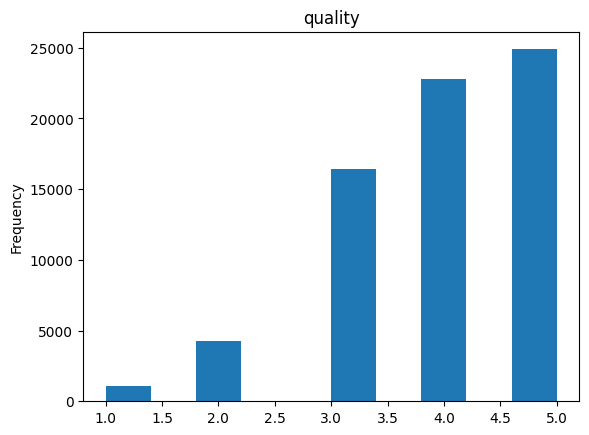

In [14]:
from matplotlib import pyplot as plt
df['quality'].plot(kind='hist', title='quality')
plt.gca()

## Building train and test sets

In [15]:
df.head()

,item_id,size,quality,cup size,bra size,category,height,user_name,length,fit,user_id,review_summary,review_text
6725,152702,4,4.0,b,32,new,5ft 6in,avNYC,just right,small,668176,Too much ruching,"I liked the color, the silhouette, and the fab..."
6726,152702,4,5.0,c,34,new,5ft 6in,lanwei91,slightly short,fit,320759,Suits my body type!,From the other reviews it seems like this dres...
6727,152702,4,3.0,a,34,new,5ft 3in,angeladevoe5678,just right,fit,144785,I love the design and fit,I love the design and fit of this dress! I wo...
6728,152702,4,3.0,c,32,new,5ft 1in,Juli,slightly long,fit,52664,Beautiful Dress!,I bought this dress for work it is flattering...
6729,152702,4,5.0,c,32,new,5ft 6in,lhalton,just right,fit,155439,This is a very profession,This is a very professional look. It is Great ...


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers
from sklearn.feature_extraction.text import CountVectorizer


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [18]:
!pip install LibRecommender
from libreco.data import random_split, DatasetPure
from libreco.algorithms import NCF  # pure data,
from libreco.evaluation import evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.3 MB/s eta 0:00:00


Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
df["user"] = df["user_id"]
df["label"] = df["quality"]
#, "item", "label", "time"
df["item"] = df["item_id"]
df=df[["user","item","label"]]

In [20]:
train_data, eval_data, test_data = random_split(df, multi_ratios=[0.8, 0.1, 0.1])


In [21]:
train_data, data_info= DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [22]:
ncf = NCF(
    task="rating",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=16,
    n_epochs=10,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
)

In [23]:
ncf.fit(
    train_data,
    neg_sampling=False, #for rating, this param is false else True
    verbose=2,
    eval_data=eval_data,
    metrics=["loss"],
)

# do final evaluation on test data
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["loss"],
)

/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
Instructions for updating:
Colocations handled automatically by placer.


Training start time: 2024-05-03 19:22:31


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
train: 100%|██████████| 55/55 [00:01<00:00, 40.35it/s]


Epoch 1 elapsed: 1.374s
	 train_loss: 13.3049


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


	 eval rmse: 2.4300


train: 100%|██████████| 55/55 [00:01<00:00, 43.78it/s]


Epoch 2 elapsed: 1.268s
	 train_loss: 1.8538


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 89.84it/s]


	 eval rmse: 1.1204


train: 100%|██████████| 55/55 [00:01<00:00, 50.44it/s]


Epoch 3 elapsed: 1.099s
	 train_loss: 0.5019


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 37.16it/s]


	 eval rmse: 1.1437


train: 100%|██████████| 55/55 [00:01<00:00, 39.23it/s]


Epoch 4 elapsed: 1.430s
	 train_loss: 0.266


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 55.98it/s]


	 eval rmse: 1.0557


train: 100%|██████████| 55/55 [00:01<00:00, 44.22it/s]


Epoch 5 elapsed: 1.267s
	 train_loss: 0.1824


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


	 eval rmse: 1.0563


train: 100%|██████████| 55/55 [00:01<00:00, 47.28it/s]


Epoch 6 elapsed: 1.186s
	 train_loss: 0.1497


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 79.28it/s]


	 eval rmse: 1.0474


train: 100%|██████████| 55/55 [00:01<00:00, 47.27it/s]


Epoch 7 elapsed: 1.195s
	 train_loss: 0.1212


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 69.78it/s]


	 eval rmse: 1.0587


train: 100%|██████████| 55/55 [00:01<00:00, 50.13it/s]


Epoch 8 elapsed: 1.108s
	 train_loss: 0.1019


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 74.46it/s]


	 eval rmse: 1.0566


train: 100%|██████████| 55/55 [00:01<00:00, 52.32it/s]


Epoch 9 elapsed: 1.071s
	 train_loss: 0.0944


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 61.32it/s]


	 eval rmse: 1.0460


train: 100%|██████████| 55/55 [00:01<00:00, 52.25it/s]


Epoch 10 elapsed: 1.061s
	 train_loss: 0.0857


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


	 eval rmse: 1.0397


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 68.53it/s]


{'loss': 1.0199189}

In [24]:
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["mae"],
)

eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 70.46it/s]


{'mae': 0.83449364}

In [25]:
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["rmse"],
)

eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 52.49it/s]


{'rmse': 1.0199189}

In [26]:
preds = []
actual = []
for i, row in df.iterrows():
    preds.append(round(ncf.predict(row["user"],row['item'])[0]))
    actual.append(round(row['label']))

Streaming output truncated to the last 5000 lines.
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 

In [27]:
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(actual, preds, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.43804881546341506
Recall: 0.32976597242074307
F1 Score: 0.31970811905524826


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

ncf.save('ncf','/content/drive/MyDrive/295A project/Data/Clothes/Models/')

file folder ncf doesn't exists, creating a new one...


In [ ]:
loaded_model = NCF.load("/content/drive/MyDrive/295A project/Data/Clothes/Models/ncf")


TypeError: ignored